# Asian Options Pricing

Implementation of quantum Monte Carlo method based on (Montanaro, 2017) for option pricing using Qiskit. The implementation compares standard Monte Carlo simulation with a quantum Monte Carlo approach for estimating the price of an arithmetic Asian call option.

In [1]:
import numpy as np
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
import random
import itertools

from qiskit.circuit.library import RYGate, GroverOperator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import Sampler
from qiskit_finance.circuit.library.probability_distributions import NormalDistribution
from qiskit_algorithms import AmplitudeEstimation, EstimationProblem

Option parameters

In [2]:
S_0 = 100       # asset price
K = 50          # strike price
sigma = 0.2     # volatility (%)
r = 0.05        # risk-free rate (%)
T=1             # time to maturity (years)

parameters = {'S_0': S_0,
              'K': K,
              'sigma': sigma,
              'r': r,
              'T': T}

Define functions

In [3]:
def standard_MC(M, k, parameters):
    """
    This function computes the price for an arithmetic average 
    Asian call option with k time steps by generating M samples. 

    Parameters:
    M (int): Number of samples
    k (int): Number of time steps.
    parameters (dict): Dictionary containing option parameters S_0, K, sigma, r, T.

    Returns:
    C0 (float): Estimate of option price.
    """

    S_0 = parameters['S_0']
    K = parameters['K']
    sigma = parameters['sigma']
    r = parameters['r']
    T = parameters['T']
    dt = T/k

    sum_CT = 0
    sum_CT2 = 0

    nudt = (r-0.5*sigma**2)*dt
    voldt = sigma*np.sqrt(dt)

    for _ in range(M):
        
        log_returns = []

        # generate log returns for each time step
        for j in range(k):
            epsilon = np.random.normal()
            log_returns.append(nudt + epsilon*voldt)

        price_path = []
        
        # calculate price path
        for j in range(len(log_returns)):
            R_t = 1
            for i in range(j+1):
                R_t = R_t*np.exp(log_returns[i])
            
            price_path.append(S_0*R_t)

        # calculate payoff
        A = np.mean(price_path)
        CT = max(0, A-K)

        sum_CT = sum_CT + CT
        sum_CT2 = sum_CT2 + CT**2

    # calculate discounted expected payoff
    C0 = np.exp(-r*T)*sum_CT/M

    # calculate standard error 
    std = np.sqrt((sum_CT2-sum_CT*sum_CT/M)*np.exp(-2*r*T)/(M-1))
    SE = std/np.sqrt(M)

    return C0


def discrete_standard_MC(M, k, parameters, n, trunc_level):
    """
    This function computes the price for an arithmetic average 
    Asian call option with k time steps by generating M samples
    using discrete probability distribution. 

    Parameters:
    M (int): Number of samples
    k (int): Number of time steps.
    parameters (dict): Dictionary containing option parameters S_0, K, sigma, r, T.
    n (int): Discretization level for normal distribution.
    trunc_level (int): Truncation level for normal distribution.

    Returns:
    C0 (float): Estimate of option price.

    """

    S_0 = parameters['S_0']
    K = parameters['K']
    sigma = parameters['sigma']
    r = parameters['r']
    T = parameters['T']
    dt = T/k

    sum_CT = 0
    sum_CT2 = 0
  
    nudt = (r-0.5*sigma**2)*dt
    voldt = sigma*np.sqrt(dt)

    # discretize the normal distribution
    points = np.linspace(nudt-trunc_level*voldt, nudt+trunc_level*voldt, 2**n)
    pdf = [1/(voldt*(2*math.pi)**0.5)*math.exp(-1/2*((z-nudt)/voldt)**2) for z in points]

    test = []

    for _ in range(M):
        
        # generate log returns using the discrete distribution
        log_returns = []

        for j in range(k):
            log_returns.append(random.choices(points, pdf)[0])

        # calculate price path
        price_path = []
        for j in range(len(log_returns)):
            R_t = 1
            for i in range(j+1):
                R_t = R_t*np.exp(log_returns[i])
            
            price_path.append(S_0*R_t)

        # calculate payoff  
        A = np.mean(price_path)
        CT = max(0, A-K)

        sum_CT = sum_CT + CT
        sum_CT2 = sum_CT2 + CT**2

    # calculate discounted expected payoff
    C0 = np.exp(-r*T)*sum_CT/M

    # calculate discounted expected payoff
    std = np.sqrt((sum_CT2-sum_CT*sum_CT/M)*np.exp(-2*r*T)/(M-1))
    SE = std/np.sqrt(M)

    return C0


def generate_price_paths(k, parameters, n, trunc_level):
    """
    This function generates all the possible price 
    paths from the log-returns.

    Parameters:
    k (int): Number of time steps.
    parameters (dict): Dictionary containing option parameters S_0, K, sigma, r, T.
    n (int): Discretization level for normal distribution.
    trunc_level (int): Truncation level for normal distribution.

    Returns:
    price_paths (list): List of all possible price paths.
    """

    S_0 = parameters['S_0']
    sigma = parameters['sigma']
    r = parameters['r']
    T = parameters['T']
    dt = T/k

    nudt = (r-0.5*sigma**2)*dt
    voldt = sigma*np.sqrt(dt)

    # discretize the normal distribution
    points = np.linspace(nudt-trunc_level*voldt, nudt+trunc_level*voldt, 2**n)

    # generate all possible paths
    sample_paths = list(itertools.product(*[list(points) for _ in range(k)]))

    price_paths = []

    # calculate price path
    for i in range(len(sample_paths)):
        
        log_returns = sample_paths[i]
        price_path = []
        
        for j in range(len(log_returns)):
            R_t = 1

            for x in range(j+1):
                R_t = R_t*np.exp(log_returns[x])
            price_path.append(S_0*R_t)
        
        price_paths.append(price_path)

    return price_paths


def payoff_function(k, parameters, n, trunc_level):
    """
    This function calculates the payoff of each price path
    and assigns it to a bit string.

    Parameters:
    k (int): Number of time steps.
    parameters (dict): Dictionary containing option parameters S_0, K, sigma, r, T.
    n (int): Discretization level for normal distribution.
    trunc_level (int): Truncation level for normal distribution.

    Returns:
    mapping (dict): Mapping of bit strings to their corresponding payoffs.
    """
    K = parameters['K']

    price_paths = generate_price_paths(k, parameters, n, trunc_level)

    # calculate payoff for each path
    payoffs = [max(np.mean(path)-K,0) for path in price_paths]
    
    # generate bit strings
    bits = [format(i, f'0{n}b') for i in range(2**n)]
    bits_combined = list(itertools.product(*[bits for _ in range(k)]))
    bits_combined = [''.join(x) for x in bits_combined]

    # create mapping
    mapping = dict(zip(bits_combined, payoffs))

    return mapping

In [4]:
# functions to split the values into disjoiint intervals

def A_1(value, x):
    """
    Returns the value if it is less than x, otherwise return 0.
    """
    if value < x:
        res = value
    else:
        res = 0 
    return res

def A_2(value, x, y):
    """
    Returns the value if it is between x and y 
    (inclusive of x, exclusive of y), otherwise return 0.
    """

    if value >= x and value < y:
        res = value
    else:
        res = 0 
    return res

def A_3(value, y):
    """
    Returns the value if it is greater than or equal to y, 
    otherwise return 0.
    """ 
    if value >= y:
        res = value
    else:
        res = 0 
    return res

def state_function(state, value, qc, n, k):
    """
    Applies controlled rotations based on the state and value.

    Parameters:
    state (str): The bit string representing the state.
    value (float): The value for rotation.
    qc (QuantumCircuit): The quantum circuit.
    n (int): Number of qubits per time step.
    k (int): Number of time steps.
    """
    
    for i in range(len(state)):
        if state[i] == '0':
            qc.x([len(state)-i])

    # calculate the rotation angle
    theta = math.asin(value**0.5)*2    

    # create a controlled RY gate
    rot = RYGate(theta).control(len(state))

    # apply the controlled rotation 
    qc.append(rot, [i+1 for i in range(n*k)]+[0])
    
    for i in range(len(state)):
        if state[i] == '0':
            qc.x([len(state)-i]) 


def V_operator(qc):
    """
    Applies the phase oracle (V operator) to the quantum circuit.

    Parameters:
    qc (QuantumCircuit): The quantum circuit.
    """
    qc.h([0])
    qc.x([0])
    qc.h([0])


def probability_loading(k, parameters, n, trunc_level):
    """
    Creates a gate to load the probability distribution for normal distribution.

    Parameters:
    k (int): Number of time steps.
    parameters (dict): Dictionary containing the option parameters.
    n (int): Number of qubits per time step.
    trunc_level (int): Truncation level for normal distribution.

    Returns:
    Gate: The gate to load the probability distribution.
    """

    sigma = parameters['sigma']
    r = parameters['r']
    T = parameters['T']
    dt = T/k

    nudt = (r-0.5*sigma**2)*dt
    voldt = sigma*np.sqrt(dt)

    # create the normal distribution gate
    qc = NormalDistribution(n, mu=nudt, sigma=voldt**2, bounds=(nudt-trunc_level*voldt, nudt+trunc_level*voldt))

    return qc.to_gate(label='P')



def run_circuit(k, n, m, probability_model, output_values):

    """
    Runs the quantum circuit for amplitude estimation.

    Parameters:
    k (int): Number of time steps.
    n (int): Number of qubits per time step.
    m (int): Number of evaluation qubits.
    probability_model (Gate): The gate representing the probability model.
    output_values (list): List of possible output_values values v(x_i).

    Returns:
    float: The estimated amplitude.
    """

    # generate bit strings
    bits = [format(i, f'0{n}b') for i in range(2**n)]
    bits_combined = list(itertools.product(*[bits for _ in range(k)]))
    bits_combined = [''.join(x) for x in bits_combined]

    # initialize quantum circuit
    qr = QuantumRegister(k*n+1)
    state_preparation = QuantumCircuit(qr)

    # load probability model for each time step    
    for i in range(k):
        state_preparation.append(probability_model, [(j+i*n)+1 for j in range(n)])

    # apply state function
    for i, amplitude in enumerate(output_values):
        state_function(state=bits_combined[i], value=amplitude, qc=state_preparation, n=n, k=k)

    # create oracle
    oracle = QuantumCircuit(QuantumRegister(k*n+1))
    V_operator(oracle)

    # create Grover operator
    Q = GroverOperator(oracle=oracle, 
                       state_preparation=state_preparation, 
                       zero_reflection=None, 
                       reflection_qubits=None, 
                       insert_barriers=False, 
                       mcx_mode='noancilla', 
                       name='Q')

    # define amplitude estimation
    sampler = Sampler()
    ae = AmplitudeEstimation(
        num_eval_qubits=m, 
        sampler=sampler,
    )

    # perform amplitude estimation
    problem = EstimationProblem(
        state_preparation=state_preparation,  # A operator
        grover_operator=Q,  # Q operator
        objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    # store result
    ae_result = ae.estimate(problem)
    
    return ae_result.estimation


def quantum_MC(k, n, m, probability_model, mapping, mean_proxy, parameters):

    """
    Runs the quantum Monte Carlo simulation.

    Parameters:
    k (int): Number of time steps.
    n (int): Number of qubits per time step.
    m (int): Number of evaluation qubits.
    probability_model (Gate): The gate representing the probability model.
    mapping (dict): Mapping of bit strings to their corresponding payoffs.
    mean_proxy (float): Mean proxy for scaling.

    Returns:
    C0 (float): The estimated price of the option.
    """
    r = parameters['r']
    T = parameters['T']

    expectation = 0
     
    # scale values  
    output_values = [value/mean_proxy for value in mapping.values()]
    
    # max number of intervals 
    j = int(np.ceil(np.log2(max(output_values))))
    
    # run circuit for the first interval [0, 1)
    values_temp = []
    for value in output_values:
        values_temp.append(A_2(value, 0, 1))
    
    res = run_circuit(k, n, m, probability_model, values_temp)
    expectation += res

    # run circuit for subsequent intervals [2^i, 2^(i+1))
    for i in range(j):
        values_temp = []
        for value in output_values:
            values_temp.append(A_2(value, 2**i, 2**(i+1))/2**(i+1))
        res = run_circuit(k, n, m, probability_model, values_temp)
        expectation += res*2**(i+1)

    return math.exp(-r*T)*expectation*mean_proxy

Plot discretization

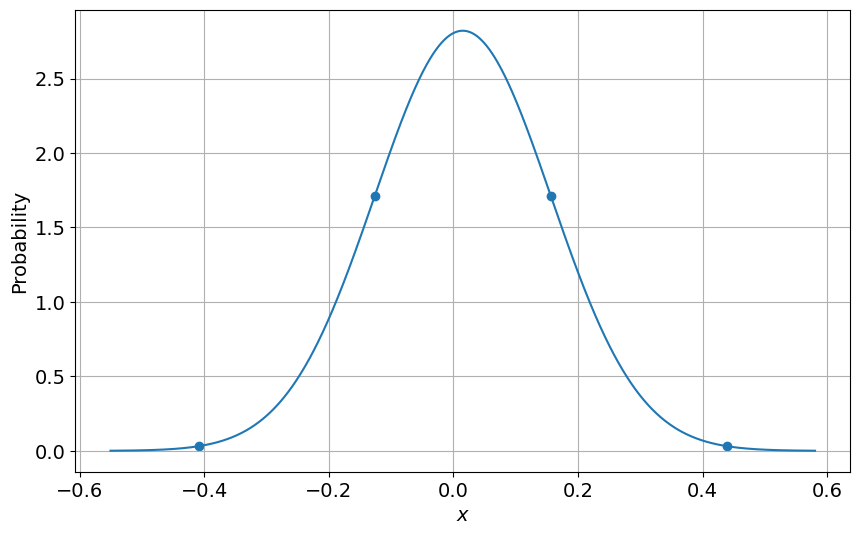

In [5]:
k = 2       # time steps
dt = T/k    # time step    
n = 2       # discretization level
trunc = 3   # truncation level

mean = (r-0.5*sigma**2)*dt
std = sigma*np.sqrt(dt)

x = np.linspace(mean-(trunc+1)*std, mean+(trunc+1)*std, 1000)
y = [1/(std*(2*math.pi)**0.5)*math.exp(-1/2*((z-mean)/std)**2) for z in x]

x_discretized = np.linspace(mean-trunc*std, mean+trunc*std, 2**n)
y_discretized = [1/(std*(2*math.pi)**0.5)*math.exp(-1/2*((z-mean)/std)**2) for z in x_discretized]

plt.figure(figsize=(10, 6))
plt.plot(x, y, linestyle='-')
plt.scatter(x_discretized, y_discretized)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.show()

Run quantum Monte Carlo experiments

In [6]:
iterations = 1
max_evaluation_qubits = 7
results_quantum = []
k = 2
n = 2
trunc_level = 3
probability_model = probability_loading(k, parameters, n, trunc_level)
mapping = payoff_function(k, parameters, n, trunc_level)
m_list = [(i+1) for i in range(max_evaluation_qubits)]

for _ in range(iterations):
    results_quantum_temp = []
    mean_proxy = discrete_standard_MC(32, k, parameters, n, trunc_level)/np.exp(-r*T)

    for m in m_list:
        res = quantum_MC(k, n, m, probability_model, mapping, mean_proxy, parameters)
        results_quantum_temp.append(res)
        print(m, res)
        
    results_quantum.append(results_quantum_temp)


1 0.0
2 75.77364598893013
3 75.77364598893013
4 46.77632951148998
5 53.45583197275457
6 49.59661451204517
7 51.90991320201762


Run standard Monte Carlo experiments

In [37]:
iterations = 1
max_evaluation_qubits = 7
results_standard = []
N = 2
n = 2
trunc_level = 3
m_list = [2**(i+1) for i in range(max_evaluation_qubits)]

for _ in range(iterations):
    results_standard_temp = []
    for M in m_list:
        res = discrete_standard_MC(M, N, parameters, n, trunc_level)
        results_standard_temp.append(res)
    
    results_standard.append(results_standard_temp)